## 설정 

In [3]:
# upload the kaggle token
from google.colab import files
kaggle_token = files.upload()

Saving kaggle.json to kaggle.json


In [4]:
# download kaggle datasets by kaggle API
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d vivek468/superstore-dataset-final
!unzip -q /content/superstore-dataset-final.zip

100% 550k/550k [00:00<00:00, 723kB/s]
100% 550k/550k [00:00<00:00, 723kB/s]


In [17]:
# install libraries needed

!pip install datasets
!pip install transformers
!pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 452 kB 32.5 MB/s 
     |████████████████████████████████| 212 kB 74.1 MB/s 
     |████████████████████████████████| 182 kB 80.9 MB/s 
     |████████████████████████████████| 132 kB 48.3 MB/s 
     |████████████████████████████████| 127 kB 79.8 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 26.9 MB/s 
     |████████████████████████████████| 7.6 MB 62.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 7.3 MB/s 
     |████████████████████████████████| 1.1 MB 39.1 MB/s 
  Created wheel for umap

## 데이터 전처리 

In [6]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
# import the data
df = pd.read_csv('Sample - Superstore.csv',
                 encoding='windows-1252')

In [8]:
df.head(3)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96,2,0.0,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.94,3,0.0,219.5820
2,3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.62,2,0.0,6.8714


In [9]:
df.columns, df.shape

(Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
        'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
        'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
        'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit'],
       dtype='object'), (9994, 21))

In [10]:
# Hackathon-like shaping
df = df[['Product Name', 'Sales', 'Category', 'Sub-Category']]

In [11]:
df.isnull().sum()

Product Name    0
Sales           0
Category        0
Sub-Category    0
dtype: int64

In [12]:
for category in df['Category'].unique():
  category_df = df[df['Category']==category]['Sub-Category']
  print(f'category={category}, {category_df.nunique()}, {category_df.unique()}\n')

category=Furniture, 4, ['Bookcases' 'Chairs' 'Tables' 'Furnishings']

category=Office Supplies, 9, ['Labels' 'Storage' 'Art' 'Binders' 'Appliances' 'Paper' 'Envelopes'
 'Fasteners' 'Supplies']

category=Technology, 4, ['Phones' 'Accessories' 'Machines' 'Copiers']



서브카테고리가 카테고리별로 중복이 없으므로, 타겟은 서브카테고리로 잡고, 카테고리는 서브카테고리가 뭐냐에 따라 if문으로 단순히 나누겠습니다.

프리트레인 모델은 분류모델에 좋은 BERT쪽 distilbert 모델을 사용하겠습니다. 

In [13]:
# drop
categories = df['Category'].unique()
df.drop(columns='Category', inplace=True)

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [87]:
df.head()

,Product Name,Sales,Sub-Category
0,Bush Somerset Collection Bookcase,261.9600,Bookcases
1,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,Chairs
2,Self-Adhesive Address Labels for Typewriters b...,14.6200,Labels
3,Bretford CR4500 Series Slim Rectangular Table,957.5775,Tables
4,Eldon Fold 'N Roll Cart System,22.3680,Storage


In [14]:
# train test split
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2, stratify=df['Sub-Category'])

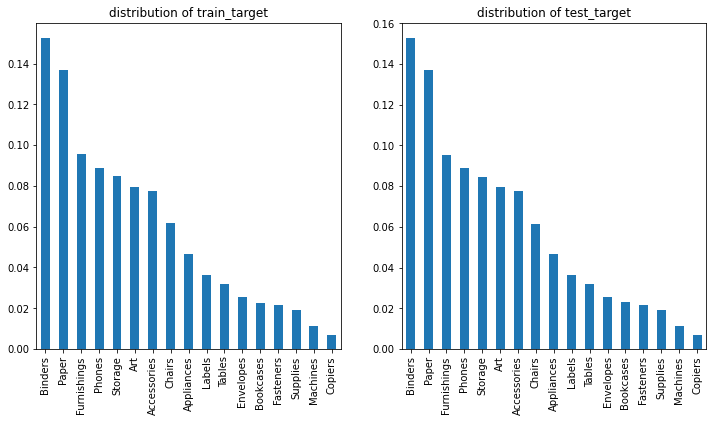

In [15]:
# check the result of split
f, ax = plt.subplots(1, 2, figsize=(12, 6))
train['Sub-Category'].value_counts(normalize=True).plot.bar(ax=ax[0])
ax[0].set_title('distribution of train_target')
test['Sub-Category'].value_counts(normalize=True).plot.bar(ax=ax[1])
ax[1].set_title('distribution of test_target')
plt.show()

In [18]:
# convert pd.DataFrame to datasets.DatasetDict
import datasets

train_dataset = datasets.Dataset.from_dict(train)
test_dataset = datasets.Dataset.from_dict(test)
dataset = datasets.DatasetDict({"train":train_dataset,"test":test_dataset})

In [19]:
dataset

DatasetDict({
    train: Dataset({
        features: ['Product Name', 'Sales', 'Sub-Category'],
        num_rows: 7995
    })
    test: Dataset({
        features: ['Product Name', 'Sales', 'Sub-Category'],
        num_rows: 1999
    })
})

## 토크나이징

In [20]:
import torch
import torch.nn as nn
from transformers import AutoTokenizer

In [21]:
pretrained_model = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(pretrained_model)

# 프리트레인 모델에 사용했던 토크나이저를 가져오는 AutoTokenizer 라이브러리를 사용합니다

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [22]:
# func definition for tokenizing
def tokenize(batch):
	return tokenizer(batch['Sub-Category'], padding=True, truncation=True)

In [23]:
# tokenizing apply
dataset_tokenized = dataset.map(tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [24]:
# check the results of tokenizing
dataset_tokenized['train']['input_ids'][0:5], dataset_tokenized['train']['attention_mask'][0:5]

([[101, 6067, 102, 0, 0],
  [101, 14187, 2545, 102, 0],
  [101, 2396, 102, 0, 0],
  [101, 2338, 18382, 2015, 102],
  [101, 3259, 102, 0, 0]],
 [[1, 1, 1, 0, 0],
  [1, 1, 1, 1, 0],
  [1, 1, 1, 0, 0],
  [1, 1, 1, 1, 1],
  [1, 1, 1, 0, 0]])

## 모델링 

In [25]:
from transformers import AutoModel

In [26]:
# set the model and device
device = torch.device('cuda' if torch.cuda.is_available() else'cpu')
model = AutoModel.from_pretrained(pretrained_model).to(device)

#마찬가지로, 프리트레인모델의 모델을 자동으로 불러오는 AutoModel 라이브러리를 사용

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [27]:
# A function that outputs a hidden layer by adding dataset_tokenized to the model
def extract_hidden_states(batch):
	inputs = {k:v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names}
	with torch.no_grad():
		last_hidden_state = model(**inputs).last_hidden_state

	return {'hidden_state': last_hidden_state[:, 0].cpu().numpy()}

In [28]:
# Convert to Tensor form for input of model
dataset_tokenized.set_format('torch',
                             columns=['input_ids', 'attention_mask', 'Sub-Category'])

In [29]:
# Hidden layer output
dataset_hidden = dataset_tokenized.map(extract_hidden_states, batched=True)

  0%|          | 0/8 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [30]:
dataset_hidden

DatasetDict({
    train: Dataset({
        features: ['Product Name', 'Sales', 'Sub-Category', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 7995
    })
    test: Dataset({
        features: ['Product Name', 'Sales', 'Sub-Category', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 1999
    })
})

## 모델 학습 전, 은닉층 시각화 해보기기

In [31]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

In [32]:
X_train = np.array(dataset_hidden['train']['hidden_state'])
X_test = np.array(dataset_hidden['test']['hidden_state'])
y_train = np.array(dataset_hidden['train']['Sub-Category'])
y_test = np.array(dataset_hidden['test']['Sub-Category'])

# 시각화를 위해 넘파이 배열로 변환 (은닉층 데이터세트가 넘파이가 되었으니, 여기서부터는 배워왔던 ML 머신들을 사용할 수 있습니다)

In [33]:
X_scaled = MinMaxScaler().fit_transform(X_train)
mapper = UMAP(n_components=2, metric='cosine').fit(X_scaled)

# 2차원으로 차원을 축소하여 시각화하는 umap 알고리즘을 적용합니다 

In [34]:
df_emb = pd.DataFrame(mapper.embedding_, columns=['X', 'Y'])
df_emb['Sub-Category'] = y_train
df_emb.head(3)

# umap 알고리즘을 적용한 결과를 dataframe으로 변환합니다

,X,Y,Sub-Category
0,-19.410376,-2.294864,Supplies
1,6.201521,-1.901461,Binders
2,0.747978,19.388220,Art


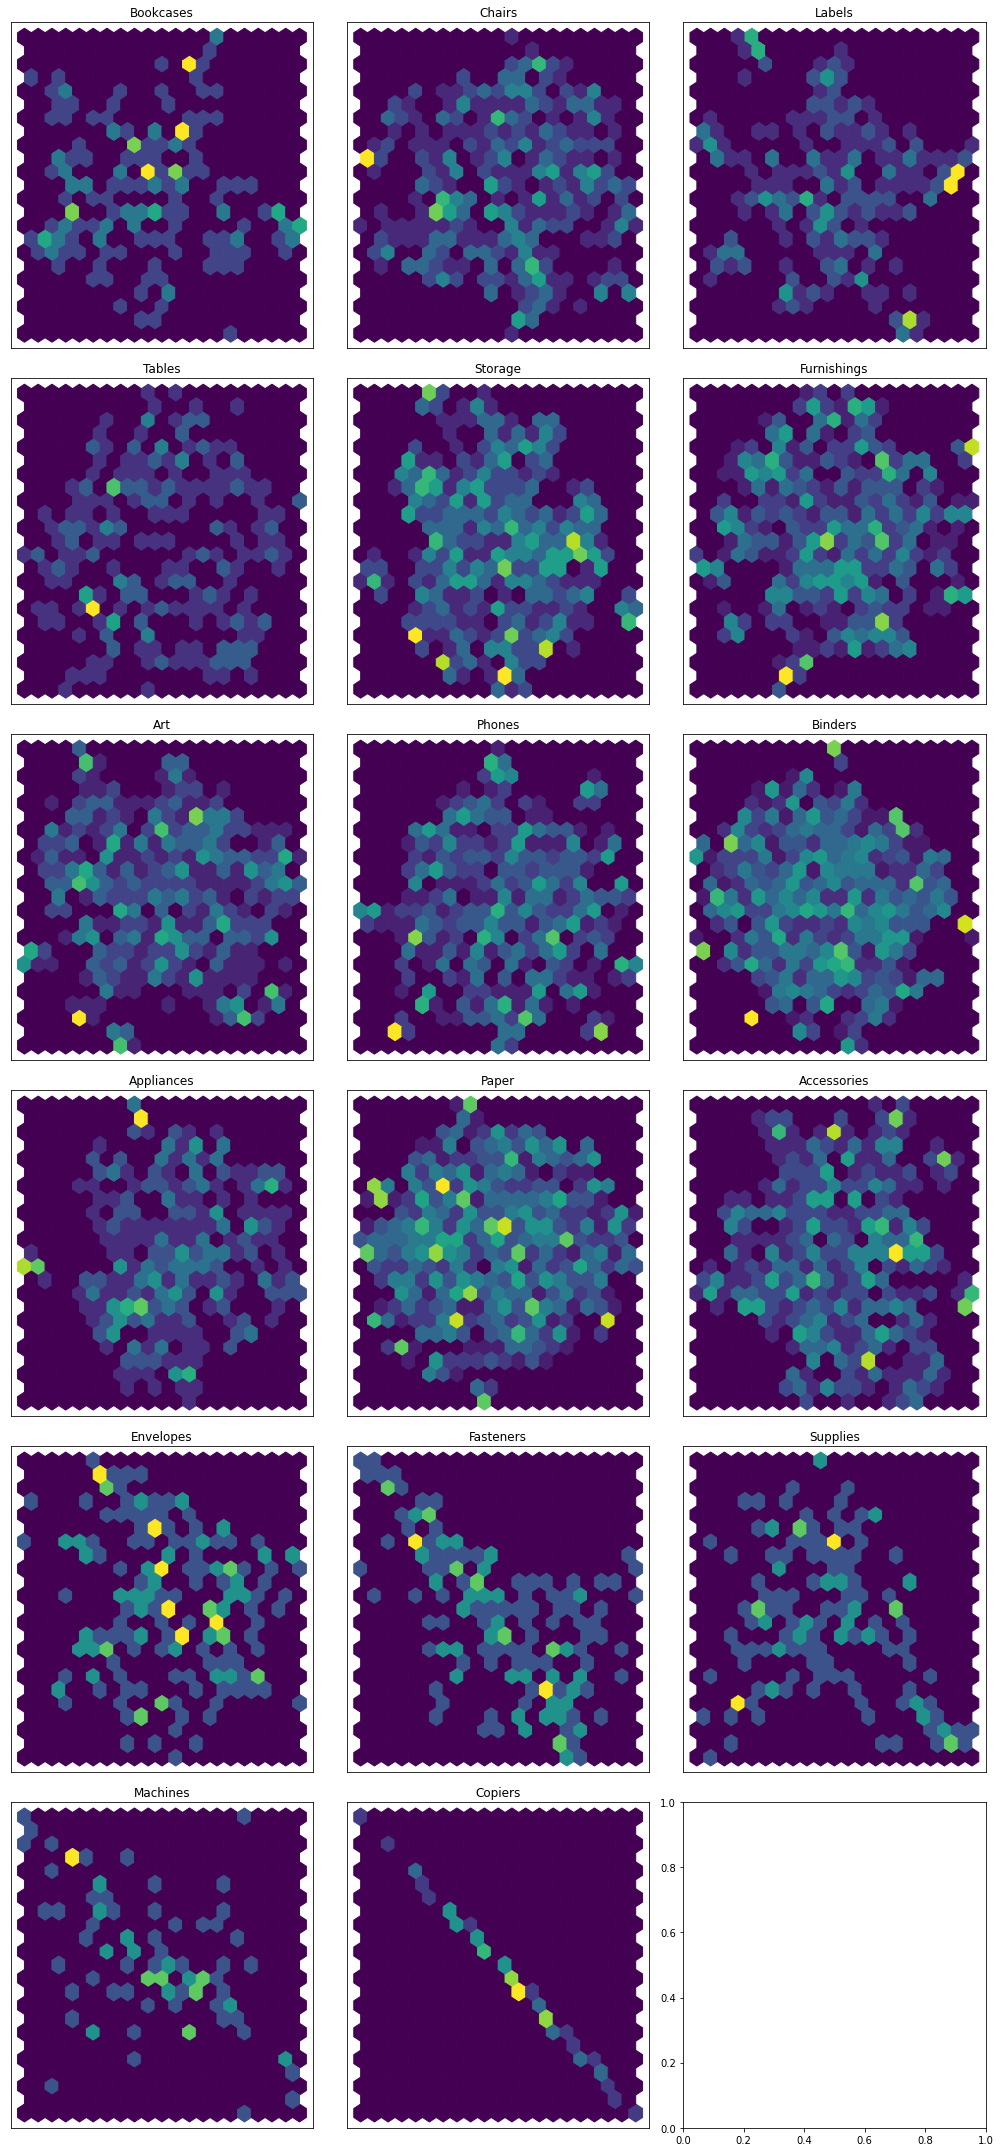

In [55]:
f, ax = plt.subplots(6, 3, figsize=(14, 30))
ax = ax.flatten()
cmaps = ['Blue', 'Orange, Purples']
labels = df['Sub-Category'].unique()

for i, label in enumerate(labels):
  df_emb_sub = df_emb[df_emb['Sub-Category'] == label]
  ax[i].hexbin(df_emb_sub['X'], df_emb_sub['Y'], gridsize=20)
  ax[i].set_title(label)
  ax[i].set_xticks([]), ax[i].set_yticks([])

plt.tight_layout()
plt.show()

# 대부분의 훈련 데이터가 구분되는 경향을 보입니다. 성능이 좋게 나올 듯 합니다.

## 모델 훈련 

In [56]:
# func def for hidden_states
def extract_hidden_states(batch):
	inputs = {k:v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names}
	with torch.no_grad():
		last_hidden_state = model(**inputs).last_hidden_state

	return {'hidden_state': last_hidden_state[:, 0].cpu().numpy()}

In [89]:
# Logisitic Regressor for baseline model
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter=100)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_test, y_test)

# 데이터 누수가 있는 것 같습니다??? 

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


1.0

In [77]:
df.head()

,Product Name,Sales,Sub-Category
0,Bush Somerset Collection Bookcase,261.9600,Bookcases
1,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,Chairs
2,Self-Adhesive Address Labels for Typewriters b...,14.6200,Labels
3,Bretford CR4500 Series Slim Rectangular Table,957.5775,Tables
4,Eldon Fold 'N Roll Cart System,22.3680,Storage


In [81]:
pd.options.display.max_columns = None
pd.options.display.max_rows = 100

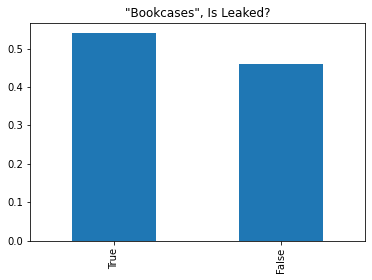

In [86]:
df[df['Sub-Category'] == 'Bookcases']['Product Name'].apply(lambda string: 'Bookcases' in string).value_counts(normalize=True).plot.bar(plt.title('"Bookcases", Is Leaked?'))